Here visuzilation of cosine similarity distribution is performed.

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from face_lib.dataset_classes.lightning_datasets import MXFaceDataset
from face_lib.models.scf import SoftmaxWeights

In [2]:
# ms1m_data = np.load("/app/cache/features/ms1m_emb.npz")
# labels = np.load("/app/datasets/ms1m/labels.npy")

In [3]:
# radius = 64
# features = torch.tensor(ms1m_data["embs"], dtype=torch.float32)
# softmax_weights = SoftmaxWeights(
#     softmax_weights_path="/app/model_weights/backbone/ms1mv3_arcface_r50/softmax_weight.pt",
#     radius=radius,
# ).softmax_weights
# wc = softmax_weights[labels, :]
# cosine_sim = torch.sum(features * wc, dim=1, keepdim=True) / radius
# cosine_sim = cosine_sim[:, 0].numpy()
# np.save("/app/model_weights/ms1m_cache/cosine_sim.npy", cosine_sim)

### Uniform sampling

In [4]:
cosine_sim = np.load("/app/model_weights/ms1m_cache/cosine_sim.npy")
batch_size = 400
rng = np.random.default_rng(776)

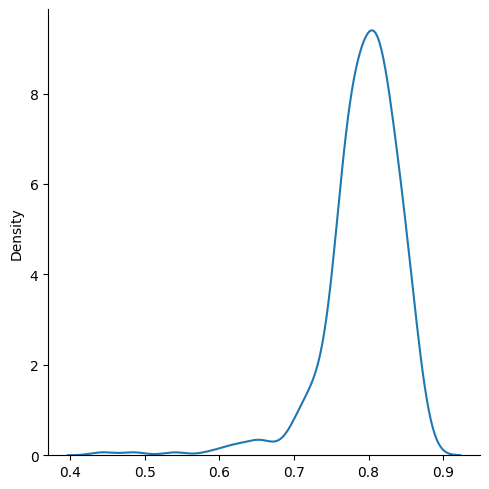

In [5]:
batch_ids = rng.choice(np.arange(cosine_sim.shape[0]), batch_size)
batch_cosine = cosine_sim[batch_ids]
sns.displot(
    batch_cosine,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

<AxesSubplot:ylabel='Count'>

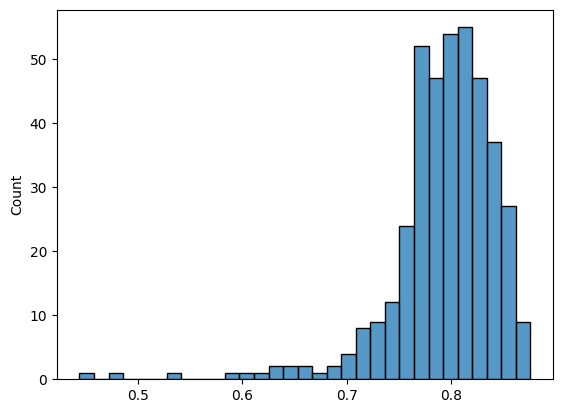

In [6]:
sns.histplot(
    batch_cosine,
    # kind="kde",
    log_scale=False,
    common_norm=False,
)

In [7]:
sorted_id_map = np.argsort(cosine_sim)

sorted_cosine_sim = np.sort(cosine_sim)
coarseness = 1
derivative_cosine_sim = np.gradient(
    sorted_cosine_sim[::coarseness], 1 / sorted_cosine_sim.shape[0]
)

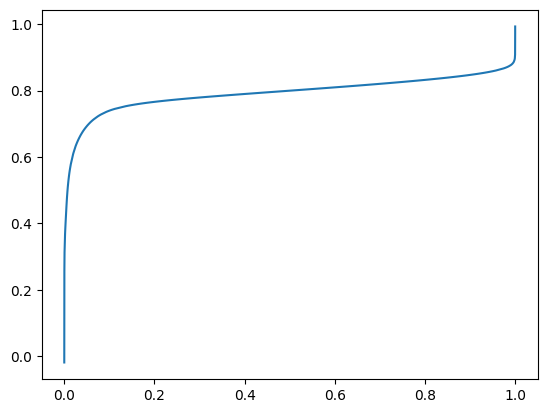

In [8]:
x_values = np.arange(sorted_cosine_sim.shape[0]) / sorted_cosine_sim.shape[0]
plt.plot(x_values, sorted_cosine_sim)
# plt.plot(x_values.numpy(), compute_function(x_values, params).detach().numpy())

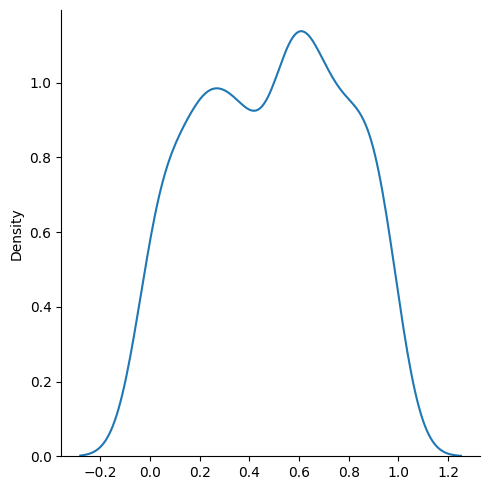

In [9]:
sorted_id_scores = np.array(
    [derivative_cosine_sim[i // coarseness] for i in range(len(sorted_id_map))]
)
sorted_batch_ids = rng.choice(
    np.arange(sorted_id_scores.shape[0]),
    batch_size,
    p=sorted_id_scores / np.sum(sorted_id_scores),
)
uniform_batch_ids = sorted_id_map[sorted_batch_ids]
uniform_batch_cosine = cosine_sim[uniform_batch_ids]
sns.displot(
    uniform_batch_cosine,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

<AxesSubplot:ylabel='Count'>

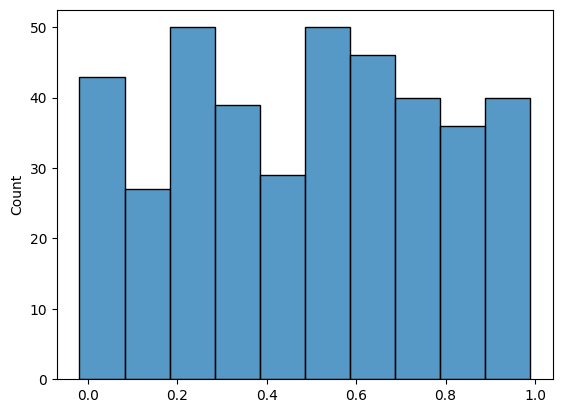

In [10]:
sns.histplot(
    uniform_batch_cosine,
    # kind="kde",
    log_scale=False,
    common_norm=False,
)

### Uniform binning

In [15]:
cosine_border_values = [0.7, 0.75, 0.8, 0.85, 1]
n_bins = len(cosine_border_values)
bin_sample_size = batch_size / n_bins
id_borders = []
id_widths = []
prev_border = 0
for cosine_border_values in cosine_border_values:
    id_border = np.searchsorted(sorted_cosine_sim, cosine_border_values)
    id_borders.append(id_border)
    id_widths.append(id_border - prev_border)
    prev_border = id_border
assert np.searchsorted(sorted_cosine_sim, 1) == sorted_cosine_sim.shape[0]

In [16]:
id_widths

[317920, 416375, 2188179, 2399689, 500490]

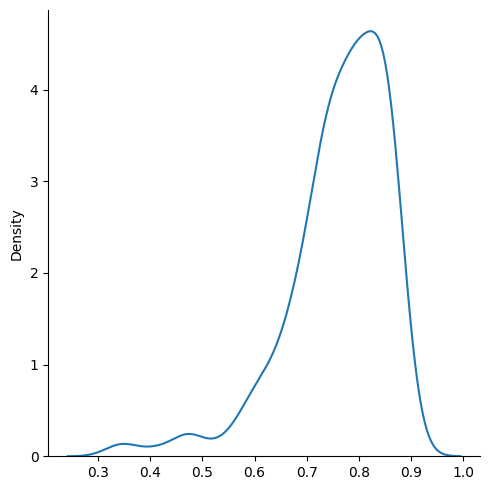

In [17]:
sorted_batch_ids = []
prev_id = 0
for id_border in id_borders:
    sorted_batch_ids.append(
        rng.choice(
            np.arange(prev_id, id_border),
            int(bin_sample_size),
        )
    )
    prev_id = id_border
sorted_batch_ids = np.concatenate(sorted_batch_ids)
uniform_batch_ids = sorted_id_map[sorted_batch_ids]
uniform_batch_cosine = cosine_sim[uniform_batch_ids]
sns.displot(
    uniform_batch_cosine,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

In [18]:
np.mean(uniform_batch_cosine)

0.7607561

<AxesSubplot:ylabel='Count'>

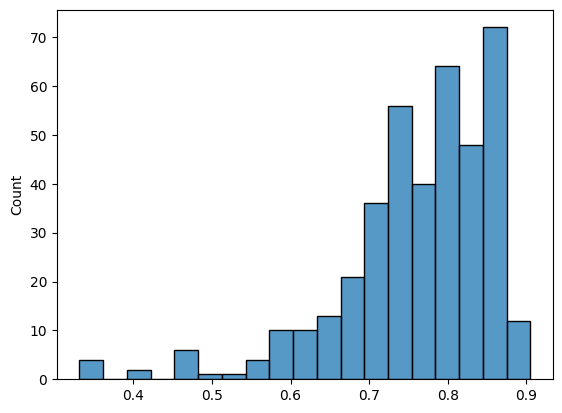

In [19]:
sns.histplot(
    uniform_batch_cosine,
    # kind="kde",
    log_scale=False,
    common_norm=False,
    #bins=[0, 0.5, 0.6, 0.7, 0.8, 1],
)

<AxesSubplot:ylabel='Count'>

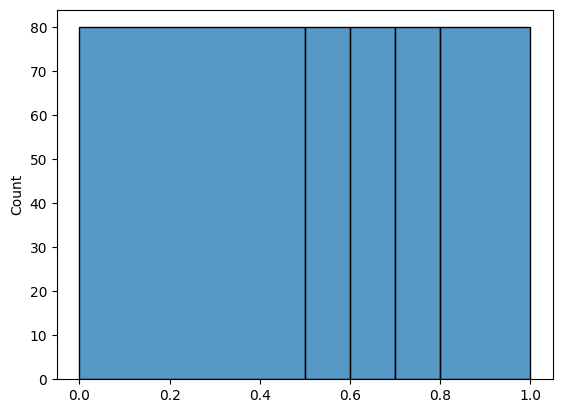

In [44]:
sns.histplot(
    uniform_batch_cosine,
    # kind="kde",
    log_scale=False,
    common_norm=False,
    bins=[0, 0.5, 0.6, 0.7, 0.8, 1],
)

Text(0.5, 9.444444444444438, 'Cosine Sim')

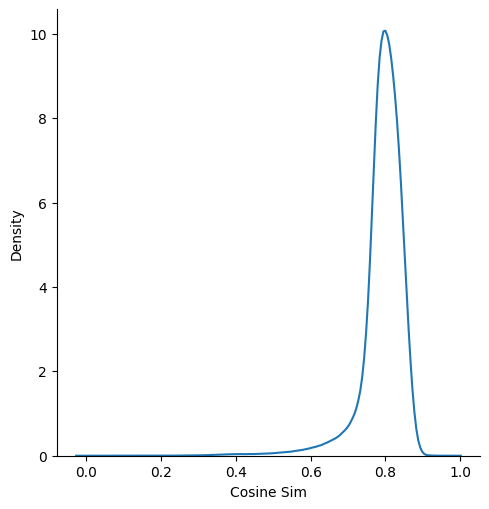

In [23]:
sns.displot(
    cosine_sim,
    kind="kde",
    # x="Cosine Sim",
    # hue="Error Kind",
    log_scale=False,
    common_norm=False,
)
plt.xlabel(f"Cosine Sim")
# plt.savefig(out_name, dpi=300)

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

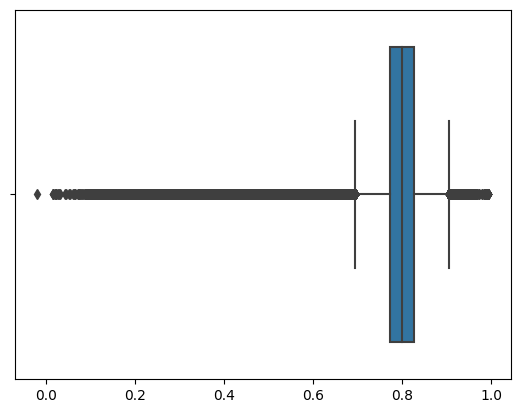

In [24]:
sns.boxplot(cosine_sim)

In [ ]:
### fit parametric curve
import torch

x_values = torch.tensor(
    np.arange(sorted_cosine_sim.shape[0]) / sorted_cosine_sim.shape[0],
    dtype=torch.float64,
)
sorted_cosine_sim_tensor = torch.tensor(sorted_cosine_sim, dtype=torch.float64)
params = {
    "a": torch.nn.Parameter(torch.tensor([1.0])),
    "b": torch.nn.Parameter(torch.tensor([1.0])),
    "c": torch.nn.Parameter(torch.tensor([1.0])),
    "d": torch.nn.Parameter(torch.tensor([1.0])),
}
optimizer = torch.optim.SGD(params=list(params.values()), lr=0.1)


def compute_function(x, params):
    return params["a"] * x**3 + params["b"] * x**2 + params["c"] * x + params["d"]


num_steps = 500
loss = torch.nn.MSELoss()
# for i in range(num_steps):
#     optimizer.zero_grad()
#     prediction = compute_function(x_values, params)
#     mse_loss = loss(prediction, sorted_cosine_sim_tensor)
#     mse_loss.backward()
#     optimizer.step()
#     print(f'iter: {i} loss: {mse_loss.item()}  ' + '_'.join([str(x.item()) for x in list(params.values())]))